# RAG Evaluation

In [1]:
import os
from datasets import load_dataset

from ragas import EvaluationDataset, evaluate
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.metrics import Faithfulness, FactualCorrectness, SemanticSimilarity, ResponseRelevancy

from ragas.llms import LangchainLLMWrapper
# from ragas.embeddings import HuggingfaceEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from dotenv import load_dotenv

load_dotenv()

g:\anaconda\anaconda3\envs\chatbot-agent\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini", temperature=0))

In [3]:
# evaluator_embeddings = LangchainEmbeddingsWrapper(HuggingfaceEmbeddings(model="BAAI/bge-m3"))
langchain_hf_embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-m3")
ragas_embeddings = LangchainEmbeddingsWrapper(langchain_hf_embeddings)

In [4]:

dataset = load_dataset(
    "json",
    data_files="../data/eval/rag/gemma3-4b.json",
    field='data',
    split='train'
)

eval_dataset = EvaluationDataset.from_hf_dataset(dataset)

Generating train split: 126 examples [00:00, 2515.19 examples/s]


In [5]:
eval_dataset[0]

SingleTurnSample(user_input='Đối tượng được dự thi tiếng Anh nội bộ', retrieved_contexts=['QUY ĐỊNH TỔ CHỨC THI TIẾNG ANH NỘI BỘ\nĐiều 4: ĐIỀU KHOẢN THI HÀNH\n\nVăn bản này có hiệu lực kể từ ngày ký và thay thế các quy định trước đây liên quan đến công tác tổ chức thi tiếng Anh nội bộ tại Đại học Bách khoa Hà Nội. Các thành viên trong Hội đồng thi và các tiểu ban có trách nhiệm thực hiện nghiêm túc các quy định tại văn bản này.', 'QUY ĐỊNH TỔ CHỨC THI TIẾNG ANH NỘI BỘ\nĐiều 2: HỘI ĐỒNG THI VÀ CÁC TIỂU BAN\n\n# 1. Hội đồng thi\n\na) Giám đốc ra quyết định thành lập Hội đồng thi (HĐT) để điều hành các công việc liên quan đến công tác tổ chức các kỳ thi tiếng Anh nội bộ theo năm học.\n\nb) Thành phần của HĐT gồm có: Chủ tịch HĐT do Phó Giám đốc phụ trách đào tạo đảm nhiệm. Các ủy viên của HĐT là đại diện lãnh đạo của các đơn vị: phòng Đào tạo (phòng ĐT), viện Ngoại ngữ (viện NN), Trung tâm Ngôn ngữ và Hỗ trợ trao đổi học thuật (trung tâm CLA), phòng Thanh tra Pháp chế (phòng TTPC) và một 

In [6]:
import nest_asyncio
nest_asyncio.apply()

metrics = [
    # LLMContextRecall(llm=evaluator_llm), 
    FactualCorrectness(llm=evaluator_llm), 
    Faithfulness(llm=evaluator_llm),
    SemanticSimilarity(embeddings=ragas_embeddings,),
    ResponseRelevancy(llm=evaluator_llm, embeddings=ragas_embeddings)
]

results = evaluate(dataset=eval_dataset, metrics=metrics)

Evaluating:  50%|████▉     | 251/504 [04:51<16:23,  3.89s/it]Exception raised in Job[156]: TimeoutError()
Exception raised in Job[157]: TimeoutError()
Evaluating: 100%|██████████| 504/504 [08:37<00:00,  1.03s/it]


In [7]:
df = results.to_pandas()

In [12]:
df.tail()

,user_input,retrieved_contexts,response,reference,factual_correctness,faithfulness,semantic_similarity,answer_relevancy
121,Ban hợp tác đối ngoại có trách nhiệm gì trong ...,[QUY ĐỊNH QUẢN LÝ HOẠT ĐỘNG HỢP TÁC ĐỐI NGOẠI\...,Theo Quy định quản lý hoạt động hợp tác đối ng...,Phòng/Ban HTĐN có vai trò sau trong tổ chức hộ...,0.00,1.000000,0.795301,0.639098
122,Giải thích khái niệm đoàn vào đoàn ra,[QUY ĐỊNH QUẢN LÝ HOẠT ĐỘNG HỢP TÁC ĐỐI NGOẠI\...,Dựa vào Quy định quản lý hoạt động hợp tác đối...,Khái niệm đoàn vào đoàn ra được giải thích như...,0.22,0.909091,0.841393,0.564889
123,Để được kết nạp đảng thì người vào đảng phải t...,[QUY ĐỊNH ĐÁNH GIÁ CÁC TCCSĐ TRỰC THUỘC ĐẢNG Ủ...,"Dựa vào các quy định trên, để được kết nạp Đản...","Để được kết nạp vào Đảng, người vào Đảng phải:...",0.67,0.363636,0.847744,0.000000
124,Trang trí buổi kết nạp Đảng viên gồm những gì,"[Buổi lễ diễn ra trang nghiêm, đúng trình tự, ...",Trang trí buổi kết nạp đảng viên gồm những nội...,Trang trí trong buổi kết nạp Đảng viên phải tr...,0.75,0.800000,0.946504,0.843007
125,Quy trình xóa tên Đảng viên đối với Đảng viên ...,[QUY ĐỊNH QUẢN LÝ CÂU LẠC BỘ SINH VIÊN 2023\nC...,Theo Quy định quản lý câu lạc bộ sinh viên 202...,Quy trình xóa tên Đảng viên dự bị là sinh viên...,0.00,1.000000,0.774813,0.558511


In [10]:
results.upload()

UploadException: Failed to upload results: {"status":"error","status_code":500,"message":"An internal server error occured"}

In [11]:
mean_values = df[['factual_correctness', 'faithfulness', 'semantic_similarity', 'answer_relevancy']].mean()

# Display the results
print(mean_values)

factual_correctness    0.544516
faithfulness           0.866581
semantic_similarity    0.851595
answer_relevancy       0.652553
dtype: float64


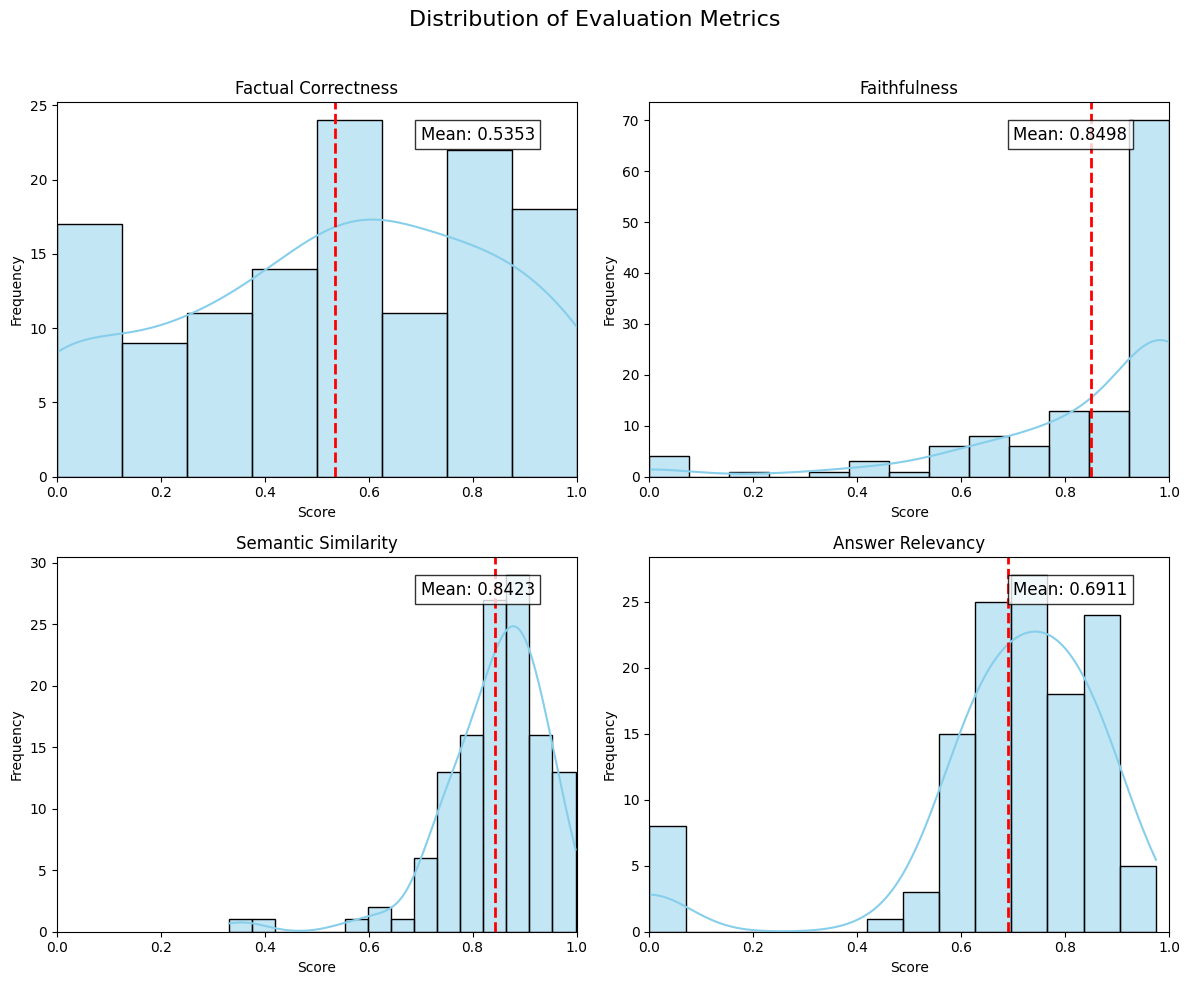

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Distribution of Evaluation Metrics', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Columns to plot
columns = ['factual_correctness', 'faithfulness', 'semantic_similarity', 'answer_relevancy']

# Create histograms for each column
for i, column in enumerate(columns):
    # Create histogram with KDE
    sns.histplot(df[column], kde=True, ax=axes[i], color='skyblue', edgecolor='black')
    
    # Add mean line
    mean_val = df[column].mean()
    axes[i].axvline(mean_val, color='red', linestyle='dashed', linewidth=2)
    axes[i].text(0.7, 0.9, f'Mean: {mean_val:.4f}', transform=axes[i].transAxes, 
                fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    
    # Set title and labels
    axes[i].set_title(f'{column.replace("_", " ").title()}')
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Frequency')
    
    # Set x-axis range (assuming scores are between 0 and 1)
    axes[i].set_xlim(0, 1)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('metric_histograms.png', dpi=300)
plt.show()

# SQL Evaluation

In [28]:
import os
import json
from datasets import load_dataset

from ragas import EvaluationDataset, evaluate
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.metrics import LLMSQLEquivalence

from ragas.llms import LangchainLLMWrapper
# from ragas.embeddings import HuggingfaceEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from dotenv import load_dotenv

load_dotenv()

True

In [21]:
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini", temperature=0))

In [ ]:
dataset = load_dataset(
    "json",
    data_files="../data/eval/text2sql/qwen2.5-7b-sql.json",
    field='data',
    split='train'
)

eval_dataset = EvaluationDataset.from_hf_dataset(dataset)

Generating train split: 133 examples [00:00, ? examples/s]


In [43]:
scorer = LLMSQLEquivalence(llm=evaluator_llm)

In [44]:
eval_dataset[0]

SingleTurnSample(user_input='Cho xin thông tin về giảng viên Lâm.', retrieved_contexts=None, reference_contexts=['Table: lecturers\n  - id: INTEGER (PRIMARY KEY) NOT NULL\n  - name: VARCHAR(100) NOT NULL\n  - title: TEXT\n  - education_path: TEXT\n  - introduction: TEXT\n  - email: VARCHAR(100)\n  - publications: TEXT\n  - awards: TEXT\n  - subjects: TEXT\n  - projects: TEXT\n  - research_field: TEXT\n  - interested_field: TEXT\n  - url: VARCHAR(255)\n'], response="SELECT DISTINCT name, title, education_path, introduction, publications, subjects, research_field, interested_field, url FROM lecturers\nWHERE name LIKE '%Lâm'\n", multi_responses=None, reference="SELECT DISTINCT name, title, introduction, email, url FROM lecturers WHERE name LIKE '%Lâm%'", rubrics=None)

In [45]:
test = await scorer.single_turn_ascore(eval_dataset[0])

In [46]:
print(test)

0


In [47]:
from tqdm import tqdm
record = []
for i, sample in tqdm(enumerate(eval_dataset)):
    sample = await scorer.single_turn_ascore(sample)
    record.append(sample)

133it [07:26,  3.36s/it]
